In [29]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm
from scipy.interpolate import interp2d

# Select a GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

# Model saving path
model_path = "model.pt"

# Train a MNIST model

TypeError: Invalid shape (1, 224, 224) for image data

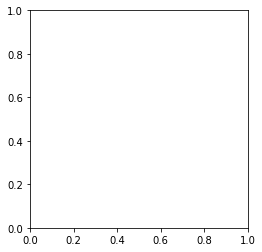

In [32]:
# Hyperparameter setting
mnist_path = "mnist"
batch_size = 32
learning_rate = 1e-4
num_show = 3

# Build the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(mnist_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(mnist_path, train=False, transform=transform)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False,
)

# Build a model
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(
    1, 
    64, 
    kernel_size=(7, 7), 
    stride=(2, 2), 
    padding=(3, 3), 
    bias=False
)  # Support gray input
model = model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [3]:
# Hyperparameters
num_epochs = 10

# Train the model
best_test_loss = np.inf
for idx_epoch in range(num_epochs):
    print(f"Epoch {idx_epoch}")
    
    # Training phase
    model.train()
    
    train_losses = []
    for image_batch, label_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda()
        output_batch = model(image_batch)
        loss = loss_fn(output_batch, label_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.detach().cpu().numpy()
        train_losses.append(loss)
        
    train_loss = np.mean(train_losses)
    print(f"Training loss: {train_loss}")
    
    # Testing phase
    model.eval()
    
    test_losses = []
    test_accuracies = []
    for image_batch, label_batch in tqdm(test_dataloader):
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda()
        output_batch = model(image_batch)
        loss = loss_fn(output_batch, label_batch)
        
        loss = loss.detach().cpu().numpy()
        test_losses.append(loss)
        
        output_label_batch = torch.argmax(output_batch, dim=-1)
        is_correct_batch = (output_label_batch == label_batch).to(float)
        is_correct_batch = is_correct_batch.detach().cpu().numpy()
        accuracy = np.mean(is_correct_batch)
        test_accuracies.append(accuracy)
        
    test_loss = np.mean(test_losses)
    test_accuracy = np.mean(test_accuracies)
    print(f"Testing loss: {test_loss}, Testing Accuracy: {test_accuracy}")
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), model_path)
        print("The model is saved.")

Epoch 0



Training loss: 0.17784926295280457



Testing loss: 0.0434325635433197, Testing Accuracy: 0.9864
The model is saved.
Epoch 1



Training loss: 0.039640381932258606



Testing loss: 0.021657254546880722, Testing Accuracy: 0.9928
The model is saved.
Epoch 2



Training loss: 0.02830028161406517



Testing loss: 0.031086670234799385, Testing Accuracy: 0.9896
Epoch 3



Training loss: 0.023811353370547295



Testing loss: 0.017559554427862167, Testing Accuracy: 0.9946
The model is saved.
Epoch 4



Training loss: 0.019223930314183235



Testing loss: 0.01813819818198681, Testing Accuracy: 0.9947
Epoch 5



Training loss: 0.01659110002219677



Testing loss: 0.03271656483411789, Testing Accuracy: 0.9899
Epoch 6



Training loss: 0.01509786956012249



Testing loss: 0.02015410177409649, Testing Accuracy: 0.9938
Epoch 7



Training loss: 0.011203767731785774



Testing loss: 0.022170349955558777, Testing Accuracy: 0.9926
Epoch 8



Training loss: 0.010825802572071552



Testing loss: 0.02019520476460457, Testing Accuracy: 0.9939
Epoch 9



Training loss: 0.007928366772830486



Testing loss: 0.020186690613627434, Testing Accuracy: 0.9936


# Generate CAM

ground truth: 7, prediction: 7


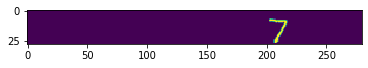

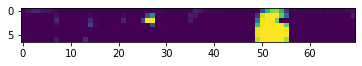

ground truth: 2, prediction: 2


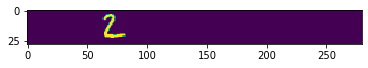

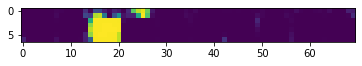

ground truth: 1, prediction: 1


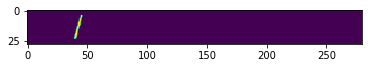

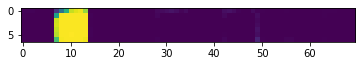

ground truth: 0, prediction: 0


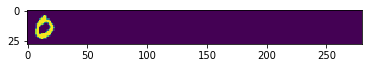

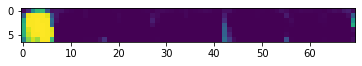

ground truth: 4, prediction: 4


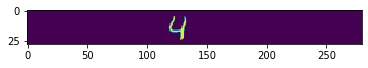

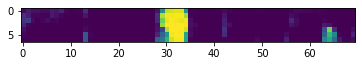

ground truth: 1, prediction: 1


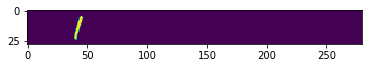

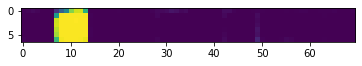

ground truth: 4, prediction: 4


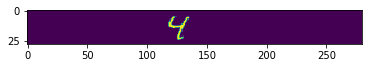

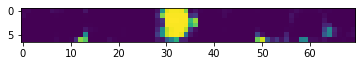

ground truth: 9, prediction: 9


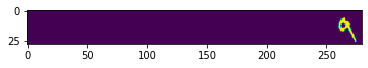

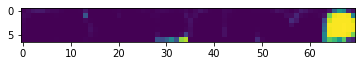

ground truth: 5, prediction: 5


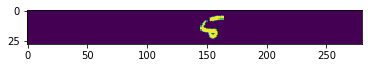

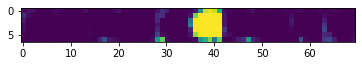

ground truth: 9, prediction: 9


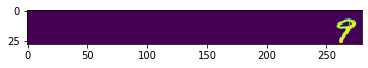

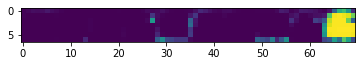

In [31]:
# Class definitions
class _Permute(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
    
    def forward(self, input_):
        return input_.permute(self.dims)

    
# Hyperparameter setting
mnist_path = "mnist"
num_samples = 10

# Build the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_dataset = datasets.MNIST(mnist_path, train=False, transform=transform)
raw_test_dataset = datasets.MNIST(mnist_path, train=False)

# Load the model
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(
    1, 
    64, 
    kernel_size=(7, 7), 
    stride=(2, 2), 
    padding=(3, 3), 
    bias=False
)  # Support gray input
model = model.cuda()
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# Build the CAM model to the trained model
cam_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    _Permute([0, 2, 3, 1]),
    model.fc,
)
cam_model = cam_model.cuda()

# Iterate the dataset to demo CAMs
model.eval()
cam_model.eval()
for idx_dataset, (image, label) in enumerate(test_dataset):
    if idx_dataset >= num_samples:
        break
    
    output = model(image.cuda()[np.newaxis, ...])[0, ...]
    output_label = torch.argmax(output).item()
    
    print(f"ground truth: {label}, prediction: {output_label}")
    
    cam = cam_model(image.cuda()[np.newaxis, ...])[0, ...]
    cam = torch.softmax(cam, dim=-1)
    cam = cam.detach().cpu().numpy()
    
    raw_image, _ = raw_test_dataset[idx_dataset]
    cam = (cam * 255.0).astype(np.uint8)
    image_row = np.hstack(
        [
            raw_image if idx == label else np.zeros_like(raw_image) 
            for idx in range(10)
        ]
    )
    cam_row = np.hstack(
        [
            cam[:, :, idx]
            for idx in range(10)
        ]
    )
    plt.imshow(image_row)
    plt.show()
    plt.imshow(cam_row)
    plt.show()